# Convolutional Auto-Encoders from the Ground-up

# Import libs that are used

Below we've listed a number of different libs and where they are used for:

- `numpy` : general computations
- `matplotlib` : Graphs & visuals
- `sklearn` : make a split (i.e. test/train) from the data we have
- `tensorflow` : For the autoencoder itself and to import the data

In [19]:
import numpy as np  # required for most computation
import cv2 as color # required to convert the images to grayscale
import matplotlib.pyplot as plt # for generating visuals
from sklearn.model_selection import train_test_split # Used to make the dataset split


# tensorflow libs
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score



In the code block below we load the data and check the dimensions of our data

In [20]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Split the training data into training (80%) and validation (10%)
x_train, val_images, y_train, val_labels = train_test_split(
    x_train, y_train, test_size=0.1111
)  # 0.1111 gives approximately a 10% validation split

# Check the shapes of the splits
print("Training data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", val_images.shape, val_labels.shape)
print("Testing data shape:", x_test.shape, x_test.shape)


Training data shape: (44445, 32, 32, 3) (44445, 1)
Validation data shape: (5555, 32, 32, 3) (5555, 1)
Testing data shape: (10000, 32, 32, 3) (10000, 32, 32, 3)


## Model initialization

![Screenshot 2024-11-08 at 08-53-31 Lab_CAE.pdf.png](<attachment:Screenshot 2024-11-08 at 08-53-31 Lab_CAE.pdf.png>)
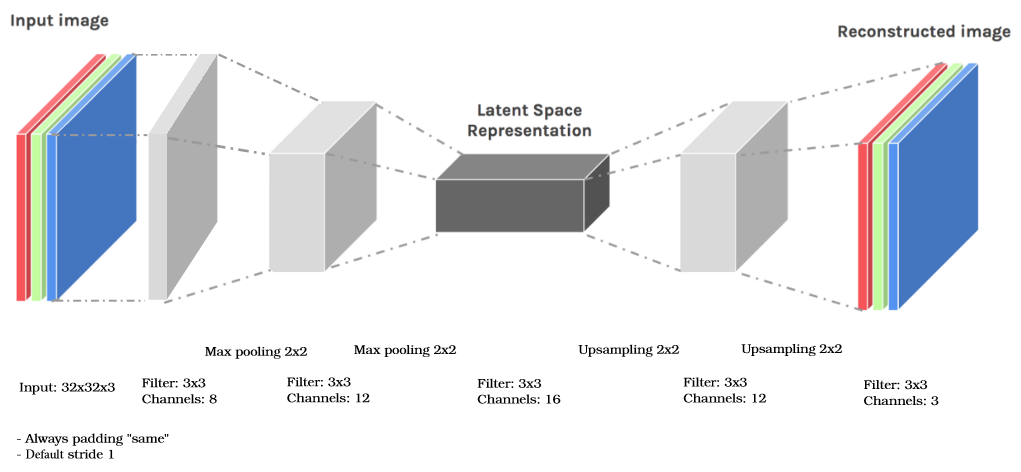

We build the model like it was requested with the following Parameters:
- Decoder
    - Convolutional Layer with a 3x3 filter and 8 channels
    - Max Pooling layer 2x2
    - Convolutional Layer with a 3x3 filter and 12 channels
    - Max Pooling layer 2x2
    - Convolutional Layer with a 3x3 filter and 16 channels
    - Max Pooling layer 2x2
- Encoder
    - Convolutional Layer with a 3x3 filter and 16 channels
    - Up scaling layer 2x2
    - Convolutional Layer with a 3x3 filter and 12 channels
    - Up scaling layer 2x2
    - Convolutional Layer with a 3x3 filter and 3 channels
    - Up scaling layer 2x2

In [21]:
class Autoencoder(Model):
  def __init__(self, input_shape):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.GaussianNoise(0.1),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 16x16x8

        layers.Conv2D(12, (3, 3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 8x8x12

        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same')  # Latent space of size 4x4x16
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
      layers.UpSampling2D((2, 2)),  # Upsample to 8x8x16

      layers.Conv2D(12, (3, 3), activation='relu', padding='same', strides=1),
      layers.UpSampling2D((2, 2)),  # Upsample to 16x16x12

      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1),
      layers.UpSampling2D((2, 2)),  # Upsample to 32x32x8

      layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)  # Output shape 32x32x3
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


input_shape = (32, 32, 3)
autoencoder = Autoencoder(input_shape)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Training

We trained the model for 50 Epochs with a batch size of 32. The hope was that we aim high enough over 10 Epochs to achieve overfitting so that we can show it in the loss-plot and later train a 'perfect' model. Since the Validation-Loss still decreased over all 50 Epochs is there no visible overfitting. 

In [53]:
history = autoencoder.fit(x_train, x_train,
                batch_size=32,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
1389/1389 [==============================] - 154s 111ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 2/50
1389/1389 [==============================] - 136s 98ms/step - loss: 0.0125 - val_loss: 0.0126
Epoch 3/50
1389/1389 [==============================] - 83s 60ms/step - loss: 0.0118 - val_loss: 0.0127
Epoch 4/50
1389/1389 [==============================] - 135s 97ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 5/50
1389/1389 [==============================] - 136s 98ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 6/50
1389/1389 [==============================] - 142s 102ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 7/50
1389/1389 [==============================] - 136s 98ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 8/50
1389/1389 [==============================] - 142s 102ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 9/50
1389/1389 [==============================] - 136s 98ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 10/50
1389/1389 [==============================

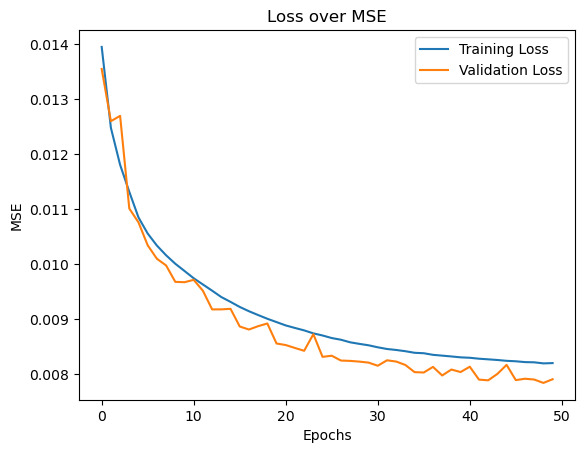

In [55]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Loss over MSE')
plt.legend()
plt.show()

In [54]:
autoencoder.save("OvertrainedModel" ,save_format="tf")

INFO:tensorflow:Assets written to: OvertrainedModel\assets


INFO:tensorflow:Assets written to: OvertrainedModel\assets


In [8]:
load_autoencoder = tf.keras.models.load_model("OvertrainedModel")

In [59]:
encoded_imgs = load_autoencoder.encoder(x_test).numpy()
decoded_imgs = load_autoencoder.decoder(encoded_imgs).numpy()

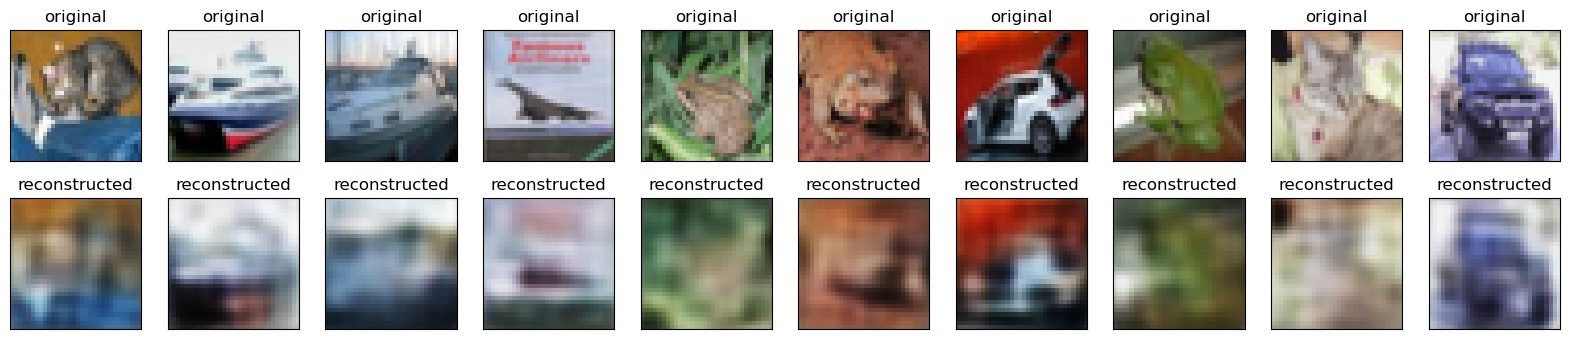

In [60]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Exercise 2

1. The size of the latent space of the Network is 4x4x16 and 2844 Parameters

In [11]:
load_autoencoder.summary()

Model: "autoencoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 4, 4, 16)          2844      
                                                                 
 sequential_5 (Sequential)   (None, 32, 32, 3)         5151      
                                                                 
Total params: 7,995
Trainable params: 7,995
Non-trainable params: 0
_________________________________________________________________


2. For this Exercise we trained a model with one more layer but we tried to use the same latend space. With the same training conditions we achieve way lower loss values.

In [4]:
class BigAutoencoder(Model):
  def __init__(self, input_shape):
    super(BigAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.GaussianNoise(0.1),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 16x16x16

        layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 8x8x32

        layers.Conv2D(24, (3, 3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 4x4x24

        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
        layers.UpSampling2D((2, 2)),  # Upsample to 8x8x16

        layers.Conv2D(24, (3, 3), activation='relu', padding='same', strides=1),
        layers.UpSampling2D((2, 2)),  # Upsample to 16x16x24

        layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
        layers.UpSampling2D((2, 2)),  # Upsample to 32x32x32

        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),

        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)  # Output shape 32x32x3
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


input_shape = (32, 32, 3)
big_autoencoder = BigAutoencoder(input_shape)

In [5]:
big_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
big_history = big_autoencoder.fit(x_train, x_train,
                batch_size=32,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
1389/1389 [==============================] - 173s 124ms/step - loss: 0.0176 - val_loss: 0.0141
Epoch 2/50
1389/1389 [==============================] - 174s 126ms/step - loss: 0.0122 - val_loss: 0.0115
Epoch 3/50
1389/1389 [==============================] - 173s 125ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 4/50
1389/1389 [==============================] - 172s 124ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 5/50
1389/1389 [==============================] - 175s 126ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 6/50
1389/1389 [==============================] - 172s 124ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 7/50
1389/1389 [==============================] - 172s 124ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 8/50
1389/1389 [==============================] - 171s 123ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 9/50
1389/1389 [==============================] - 173s 125ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 10/50
1389/1389 [=======================

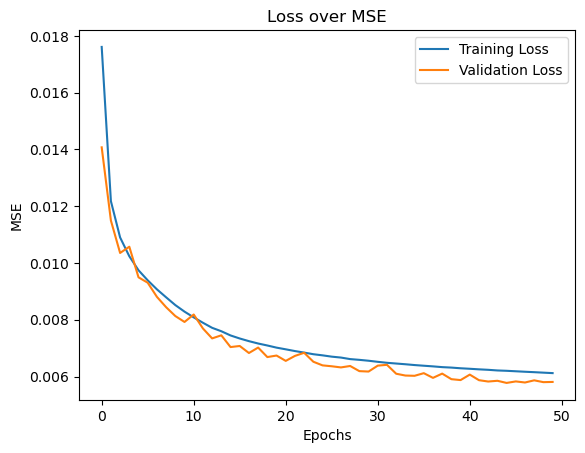

In [ ]:
plt.figure()
plt.plot(big_history.history['loss'], label='Training Loss')
plt.plot(big_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Loss over MSE')
plt.legend()
plt.show()

In [8]:
big_autoencoder.save("BiggerOvertrainedModel" ,save_format="tf")

INFO:tensorflow:Assets written to: BiggerOvertrainedModel\assets


INFO:tensorflow:Assets written to: BiggerOvertrainedModel\assets


In [9]:
encoded_imgs = big_autoencoder.encoder(x_test).numpy()
decoded_imgs = big_autoencoder.decoder(encoded_imgs).numpy()

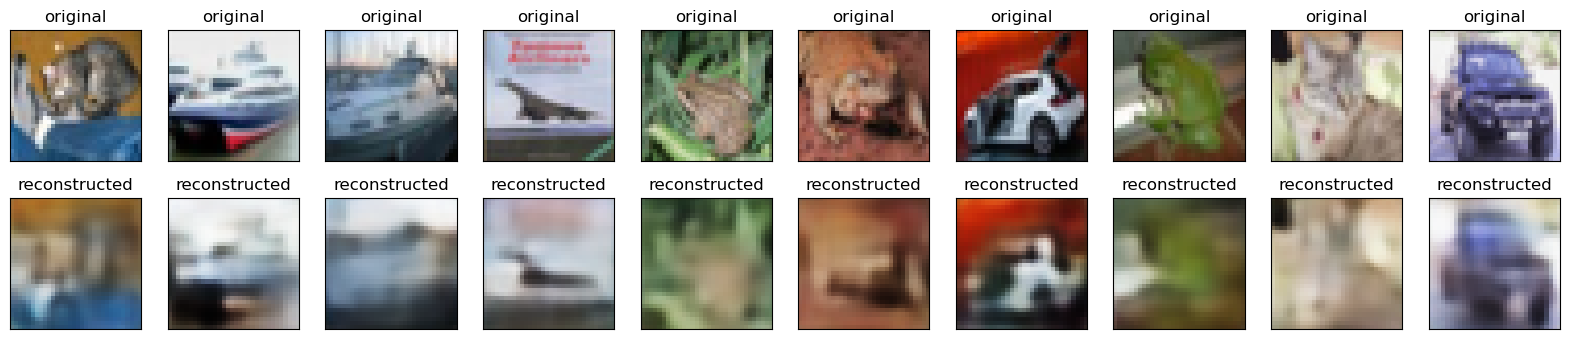

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
class SmallerAutoencoder(Model):
  def __init__(self, input_shape):
    super(SmallerAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.GaussianNoise(0.1),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 16x16x8

        layers.Conv2D(12, (3, 3), activation='relu', padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 8x8x12

        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
      layers.UpSampling2D((2, 2)),  # Upsample to 8x8x16

      layers.Conv2D(12, (3, 3), activation='relu', padding='same', strides=1),
      layers.UpSampling2D((2, 2)),  # Upsample to 16x16x12

      layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)  # Output shape 32x32x3
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


input_shape = (32, 32, 3)
smaller_autoencoder = SmallerAutoencoder(input_shape)

In [13]:
smaller_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
smaller_history = smaller_autoencoder.fit(x_train, x_train,
                batch_size=32,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
1389/1389 [==============================] - 137s 96ms/step - loss: 0.0122 - val_loss: 0.0082
Epoch 2/50
1389/1389 [==============================] - 131s 94ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 3/50
1389/1389 [==============================] - 170s 122ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 4/50
1389/1389 [==============================] - 130s 93ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 5/50
1389/1389 [==============================] - 122s 88ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 6/50
1389/1389 [==============================] - 118s 85ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 7/50
1389/1389 [==============================] - 121s 87ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 8/50
1389/1389 [==============================] - 117s 84ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 9/50
1389/1389 [==============================] - 119s 86ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 10/50
1389/1389 [==============================]

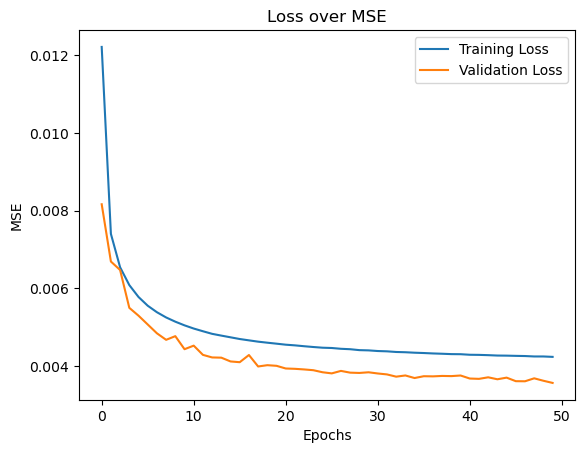

In [16]:
plt.figure()
plt.plot(smaller_history.history['loss'], label='Training Loss')
plt.plot(smaller_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Loss over MSE')
plt.legend()
plt.show()

In [15]:
smaller_autoencoder.save("SmallerOvertrainedModel" ,save_format="tf")

INFO:tensorflow:Assets written to: SmallerOvertrainedModel\assets


INFO:tensorflow:Assets written to: SmallerOvertrainedModel\assets


In [17]:
encoded_imgs = smaller_autoencoder.encoder(x_test).numpy()
decoded_imgs = smaller_autoencoder.decoder(encoded_imgs).numpy()

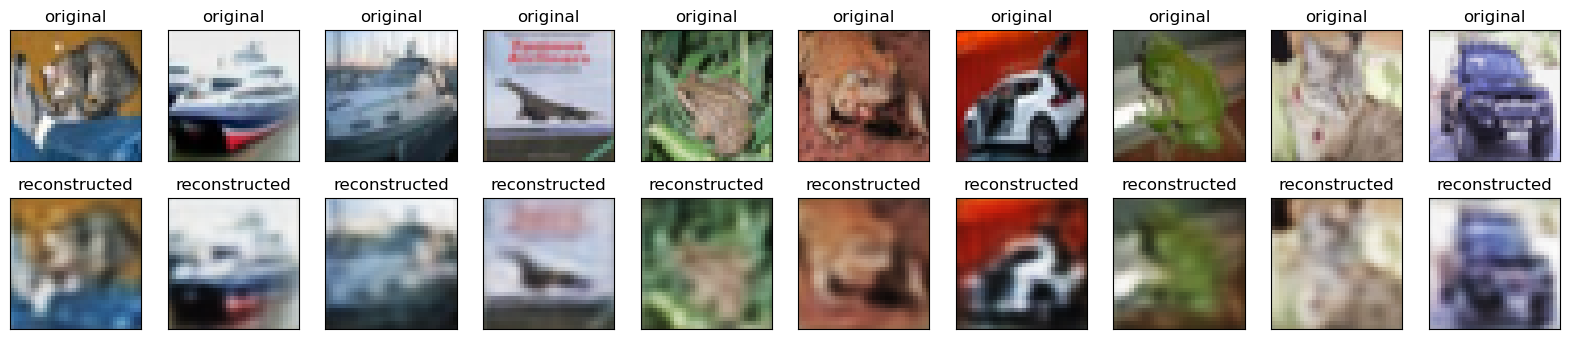

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Gray to Color AutoEncoder

In [25]:
# Lets generate a grayscale dataset

# the cvtColor func requires unnormilised images in int8 datatype 
x_train_uint8, x_test_uint8 = (x_train * 255).astype('uint8'), (x_test * 255).astype('uint8')

x_train_grayscale = np.array([color.cvtColor(img, color.COLOR_RGB2GRAY) for img in x_train_uint8]) 
x_test_grayscale = np.array([color.cvtColor(img, color.COLOR_RGB2GRAY) for img in x_test_uint8])

# normilse the grayscale images
x_train_grayscale, x_test_grayscale = x_train_grayscale / 255, x_test_grayscale / 255

input_shape_gray = (32, 32, 1)
autoEncoderGray = Autoencoder(input_shape_gray)
autoEncoderGray.compile(optimizer='adam', loss=losses.MeanSquaredError())

gray_history = autoEncoderGray.fit(x_train_grayscale, x_train,
                batch_size=32,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_grayscale, x_test))

Epoch 1/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0276 - val_loss: 0.0178
Epoch 2/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0169 - val_loss: 0.0158
Epoch 3/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 4/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 5/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 6/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 7/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 8/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 9/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 10/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 11/50
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 12

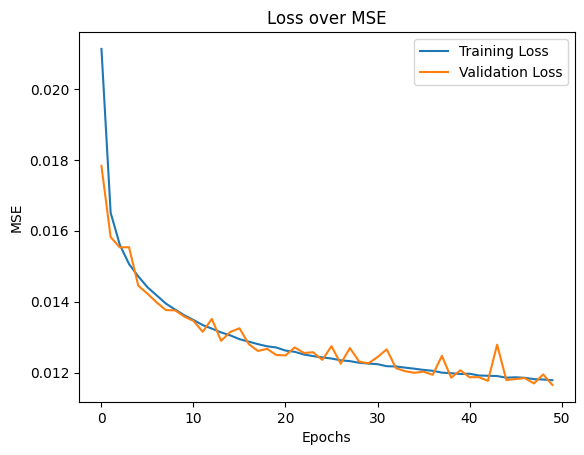

In [26]:
# Display the loss over itterations for the grayscale autoencoder

plt.figure()
plt.plot(gray_history.history['loss'], label='Training Loss')
plt.plot(gray_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Loss over MSE')
plt.legend()
plt.show()

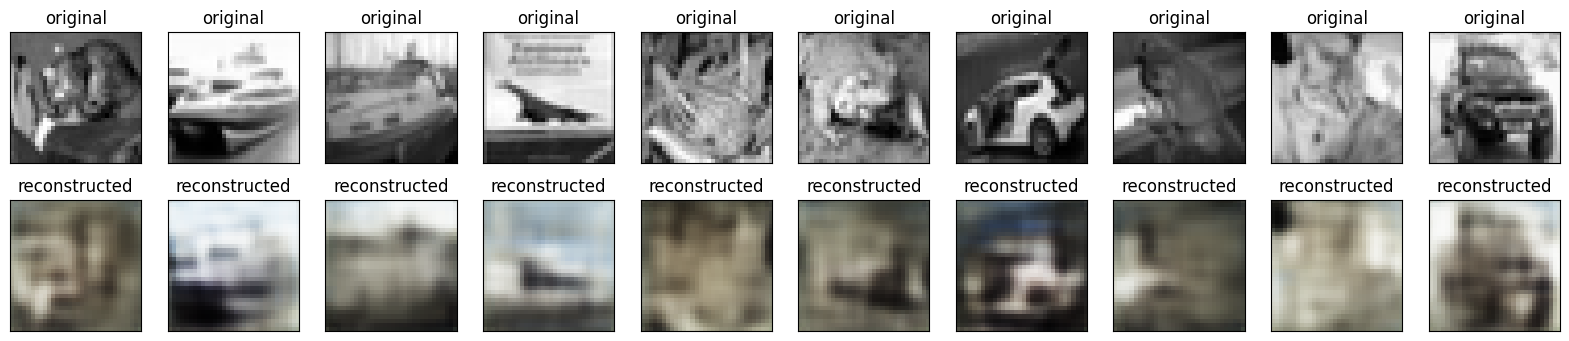

In [27]:
encoded_gray = autoEncoderGray.encoder(x_test_grayscale).numpy()
decoded_gray = autoEncoderGray.decoder(encoded_gray).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_grayscale[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_gray[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()